# Preparations

In [34]:
import os
import sys

BASE_DIR = os.path.join(os.path.abspath(""), "..")
sys.path.insert(0, BASE_DIR)

In [35]:
from clustering.birch import Birch
from data.datasource import load_X_y, load_spotify_dataset

import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn
from sklearn import cluster
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE

# Performance Check
Complexity of building the Birch Tree is $O(N)$.

If you only want the tree generation to be done, you need to set `n_cluster=None` and `predict=False` or as it is called in sklearn `compute_labels=False`

In [36]:
complete_df = load_spotify_dataset(os.path.join(BASE_DIR, "data", "SpotifyFeatures.csv"))
print(complete_df.shape)
selected_columns = [
            col
            for col in complete_df.columns
            if col not in ["genre", "artist_name", "track_name", "track_id", "key", "mode", "time_signature", "popularity"]
        ]
complete_df[selected_columns]

(232725, 18)


,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence
0,0.61100,0.389,99373,0.910,0.000000,0.3460,-1.828,0.0525,166.969,0.814
1,0.24600,0.590,137373,0.737,0.000000,0.1510,-5.559,0.0868,174.003,0.816
2,0.95200,0.663,170267,0.131,0.000000,0.1030,-13.879,0.0362,99.488,0.368
3,0.70300,0.240,152427,0.326,0.000000,0.0985,-12.178,0.0395,171.758,0.227
4,0.95000,0.331,82625,0.225,0.123000,0.2020,-21.150,0.0456,140.576,0.390
...,...,...,...,...,...,...,...,...,...,...
232720,0.00384,0.687,326240,0.714,0.544000,0.0845,-10.626,0.0316,115.542,0.962
232721,0.03290,0.785,282447,0.683,0.000880,0.2370,-6.944,0.0337,113.830,0.969
232722,0.90100,0.517,166960,0.419,0.000000,0.0945,-8.282,0.1480,84.135,0.813
232723,0.26200,0.745,222442,0.704,0.000000,0.3330,-7.137,0.1460,100.031,0.489


In [37]:
orig_brc = cluster.Birch(branching_factor=50, n_clusters=None, threshold=0.5, compute_labels=False)
start = time.time()
orig_brc.fit(complete_df[selected_columns])
end = time.time()
print(f"sklearn Birch took {round(end-start,4)} seconds")

sklearn Birch took 20.9197 seconds


In [38]:
brc = Birch(branching_factor=50, threshold=0.5, predict=False)
start = time.time()
brc.fit(complete_df[selected_columns])
end = time.time()
print(f"Custom Birch took {round(end-start,4)} seconds")

Custom Birch took 30.1267 seconds


In [39]:
print(orig_brc.subcluster_centers_.shape)
print(brc.all_centroids.shape)

(187500, 10)
(185010, 10)


The Number of clusters between both approaches may differ without specifying `leaf_factor` in my approach.

I use a heuristic where without specifying `leaf_factor` it will get the value of `branching_factor`$*2$

# Evaluation
## Small dataset
For the first evaluation, the number of entries is reduced to 500 samples per genre.

In [40]:
# Load small dataset
X,y, df= load_X_y(os.path.join(BASE_DIR, "data", "SpotifyFeatures.csv"), sample_size=500)
print(X.shape)
print(f'Number of genres: {len(set(df["genre"]))}')
genres = df["genre"].values
df.head()

(12500, 10)
Number of genres: 25


,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,genre_numeric
13499,Alternative,Noah Gundersen,Wrong Side,0vM54PL6yhlDW6um2B2Pzd,44,0.586000,0.513,209847,0.482,0.000147,C,0.140,-8.681,Major,0.0366,83.369,4/4,0.452,0
13472,Alternative,Wolfmother,Victorious,6TFGNgCyhgHKNn046iG6fa,50,0.000091,0.428,264987,0.937,0.000012,A,0.187,-3.713,Major,0.0657,80.020,4/4,0.323,0
5925,Alternative,Childish Major,Happy Birthday (feat. SZA & Isaiah Rashad),5KNoyjCDbXVPhzAX3CZsnC,49,0.033500,0.741,182692,0.780,0.000283,A#,0.117,-6.779,Minor,0.1180,117.098,4/4,0.623,0
5254,Alternative,The Roots,The Seed (2.0),1a6Jt6USVGKzbjYpcKMwPB,61,0.039000,0.758,267933,0.957,0.000000,G,0.133,-2.282,Major,0.0357,111.119,4/4,0.966,0
10454,Alternative,Hurt,Rapture,00WXjbcR195RztyuAQ90ub,44,0.006410,0.444,340667,0.702,0.000008,F#,0.217,-6.799,Major,0.0608,148.096,4/4,0.270,0


Birch has only 1 parameter directly responsible for cluster size: `threshold` which is the radius of the cluster.

It is recommended to start with a small threshold, as you can always reduce the number of clusters but not expand it.

The branching factor and leaf factor are only responsible for small changes in the number of clusters generated.

In [41]:
# setting n to 25, because we have 25 genres
brc = Birch(branching_factor=50, threshold=0.25, predict=True, n_cluster=25)
start = time.time()
brc.fit(X)
print(f"Building the tree and labelling took {round(time.time()-start,4)} seconds")
print("\n")
print(f"Dimension of centroids array: {brc.all_centroids.shape}")
print(f"Number of samples per cluster: {np.bincount(brc.labels)}")

Building the tree and labelling took 0.8625 seconds


Dimension of centroids array: (25, 10)
Number of samples per cluster: [3096  873 1120   55 1992  176  233  107  180  467  195   42  148   85
  284  436  360  830  467  142   23   53  944   54  138]


<Axes: >

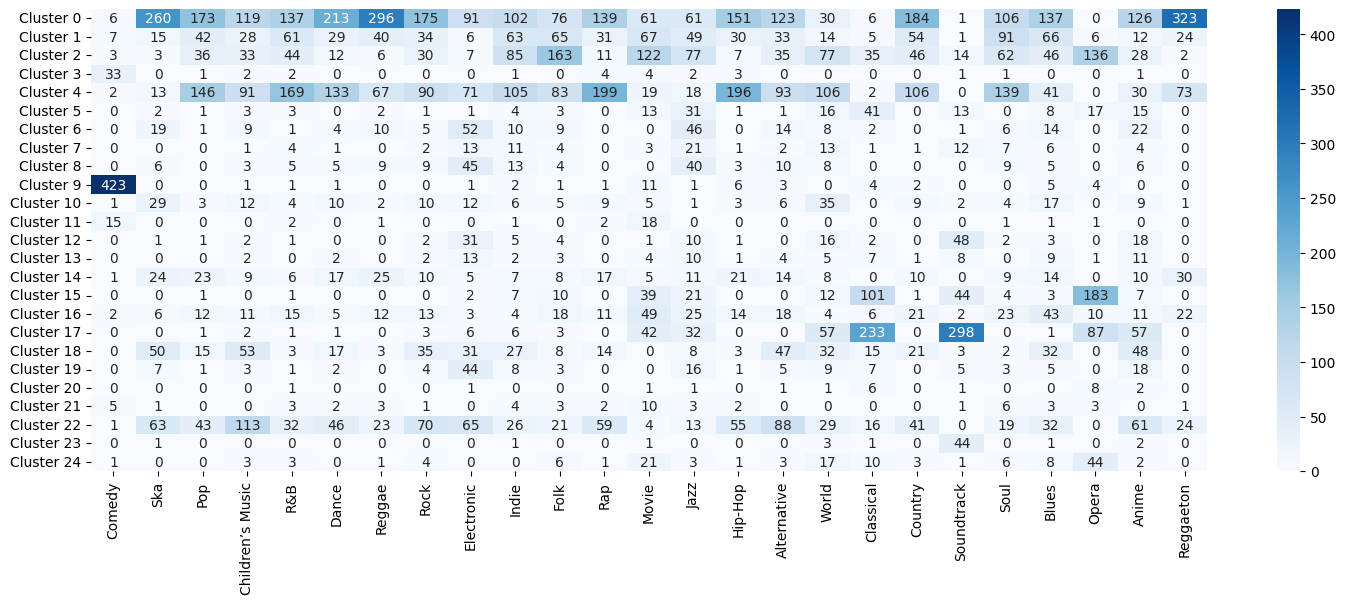

In [42]:
n_clusters = brc.all_centroids.shape[0]
genres = list(set(genres))
matrix = np.zeros((n_clusters,len(set(genres))))

# Heatmap generation Code from Florian (DBSCAN Notebook)
#
for i in range(n_clusters):
    for genre, hits in df[brc.labels == i].genre.value_counts().items():
        matrix[i, genres.index(genre)] = hits

matrix = pd.DataFrame(matrix, columns=genres, index=(f"Cluster {i}" for i in range(n_clusters)))

fig, ax = plt.subplots(figsize=(18, 6))
sn.heatmap(matrix, annot=True, ax=ax, fmt=".0f", cmap="Blues")

In [43]:
combine = np.concatenate((X,brc.all_centroids))
tsne = TSNE(n_components=2).fit_transform(combine)

transformed_X = tsne[:X.shape[0]]
transformed_subclusters = tsne[X.shape[0]:]

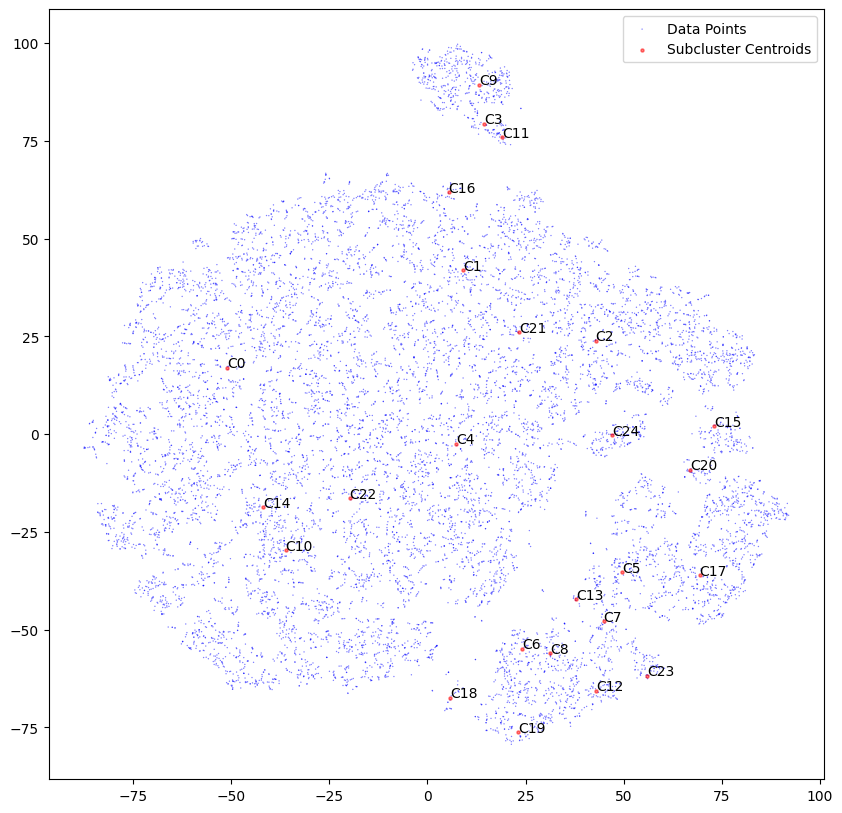

In [52]:
plt.figure(figsize=(10, 10))
plt.scatter(transformed_X[:, 0], transformed_X[:, 1], label='Data Points', c='blue', alpha=0.5, s=1, edgecolors='none', marker='o')
plt.scatter(transformed_subclusters[:, 0], transformed_subclusters[:, 1], label='Subcluster Centroids', c='red',  alpha=0.5, s=5, marker='o')
for i, c in enumerate(transformed_subclusters):
    plt.annotate(f"C{i}", (c[0], c[1]), fontsize=10)
plt.legend()
plt.show()

## Big dataset
As Birch is a fast clustering algorithm, I will try to use every row of the Spotify dataset.

Keep in mind that changing ``threshold`` or ``n_cluster`` at this stage may result in crashes.

In [45]:
# Load big dataset
complete_df = load_spotify_dataset(os.path.join(BASE_DIR, "data", "SpotifyFeatures.csv"))
complete_df = complete_df[complete_df["genre"] != "Children's Music"]
complete_df = complete_df[complete_df["genre"] != "A Capella"]

data_columns = [
            col
            for col in complete_df.columns
            if col not in ["genre","artist_name", "track_name", "track_id", "key", "mode", "time_signature", "popularity"]
        ]

minmaxscaler = MinMaxScaler()
X_total = minmaxscaler.fit_transform(complete_df[data_columns])
print(f"Number of rows: {X_total.shape[0]}")


Number of rows: 227203


In [46]:
big_brc = Birch(branching_factor=200, threshold=0.20, predict=True, n_cluster=25)
start = time.time()
big_brc.fit(X_total)
print(f"Building the tree and labelling took {time.time()-start} seconds")
print("\n")
print(f"Dimension of centroids array: {big_brc.all_centroids.shape}")
print(f"Number of samples per cluster: {np.bincount(big_brc.labels)}")

Building the tree and labelling took 19.577746629714966 seconds


Dimension of centroids array: (25, 10)
Number of samples per cluster: [24286  1148  4437 17479 41094  8819  4361 42163  1446  4846  3758   654
  3182  1314  2072  1383 11364  2970 12010  1395 27649   634  4369   305
  4065]


<Axes: >

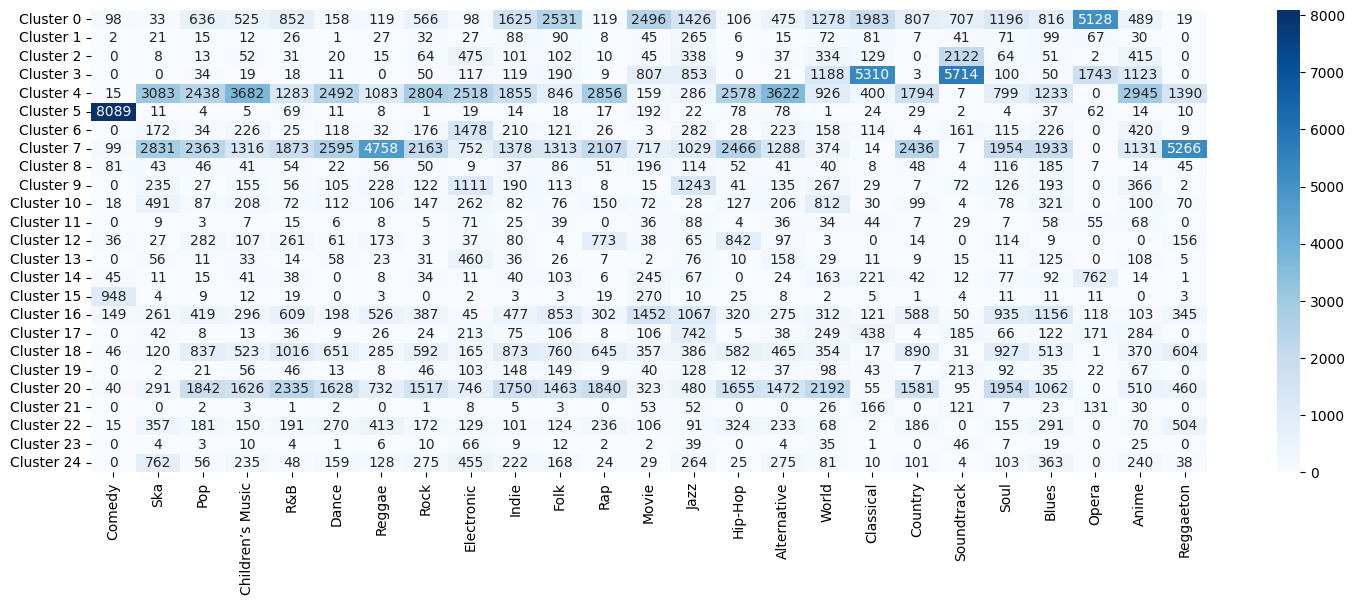

In [47]:
n_clusters = big_brc.all_centroids.shape[0]
genres = list(set(genres))
big_matrix = np.zeros((n_clusters,len(set(genres))))


# Heatmap generation Code from Florian (DBSCAN Notebook)
#
for i in range(n_clusters):
    for genre, hits in complete_df[big_brc.labels == i].genre.value_counts().items():
        big_matrix[i, genres.index(genre)] = hits

big_matrix = pd.DataFrame(big_matrix, columns=genres, index=(f"Cluster {i}" for i in range(n_clusters)))

fig, ax = plt.subplots(figsize=(18, 6))
sn.heatmap(big_matrix, annot=True, ax=ax, fmt=".0f", cmap="Blues")

# Parameters

In [48]:
# Load small dataset
X,y, df= load_X_y(os.path.join(BASE_DIR, "data", "SpotifyFeatures.csv"), sample_size=500)

threshold = np.linspace(0.1, 2, 50)
subcluster_count = []
start = time.time()
for t in threshold:
    brc = Birch(branching_factor=50, threshold=t, predict=False)
    brc.fit(X)
    subcluster_count.append(brc.all_centroids.shape[0])

print(f"time: {time.time()-start} seconds")

time: 24.587201356887817 seconds


Text(0.5, 1.0, 'Number of Subclusters depending on Threshold')

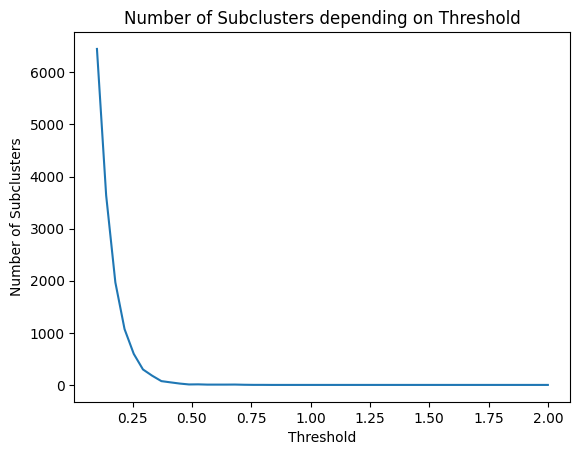

In [49]:
plt.plot(threshold,subcluster_count)
plt.xlabel("Threshold")
plt.ylabel("Number of Subclusters")
plt.title("Number of Subclusters depending on Threshold")

You always want to have the `threshold` low enough, but a low value may result in too many clusters and cause performance issues.

In [50]:
bf = np.linspace(50, 500, 100)
subcluster_count_bf = []
start = time.time()
for b in bf:
    brc = Birch(branching_factor=int(b), threshold=0.25, predict=False)
    brc.fit(X)
    subcluster_count_bf.append(brc.all_centroids.shape[0])

print(f"time for branching_factor: {time.time()-start} seconds")

lf = np.linspace(250, 750, 50)
subcluster_count_lf = []
start = time.time()
for l in lf:
    brc = Birch(branching_factor=250, threshold=0.25, predict=False, leaf_factor=int(l))
    brc.fit(X)
    subcluster_count_lf.append(brc.all_centroids.shape[0])

print(f"time for leaf_factor: {time.time()-start} seconds")

time for branching_factor: 74.87061834335327 seconds
time for leaf_factor: 41.87795281410217 seconds


Text(0, 0.5, 'Number of Subclusters')

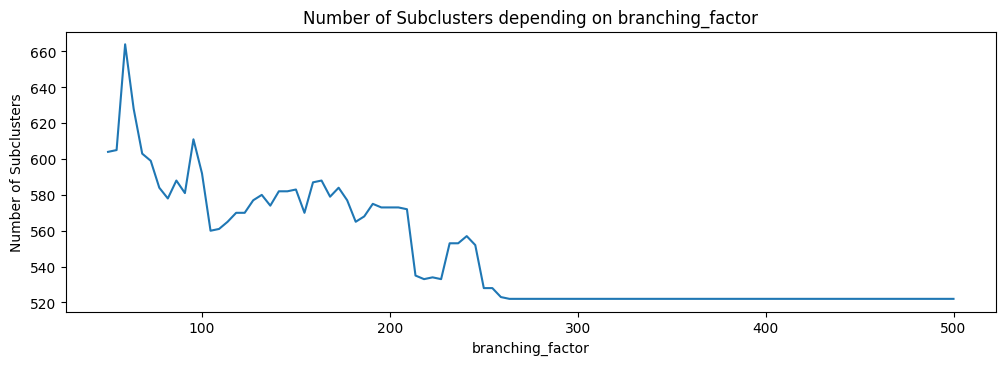

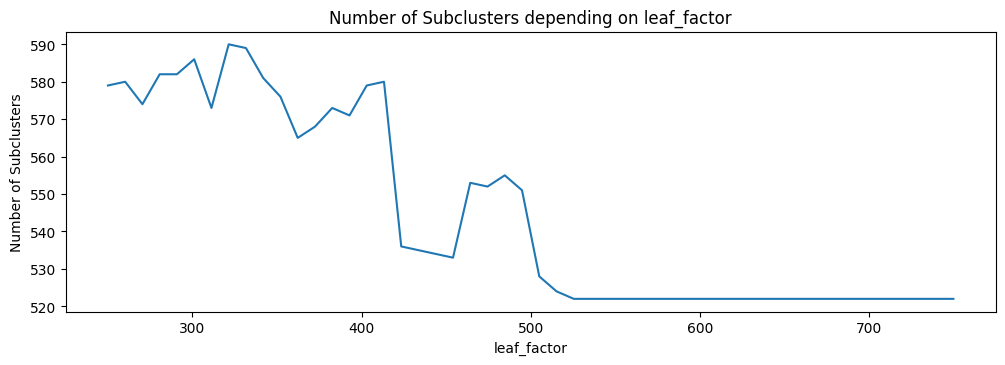

In [51]:
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(2,1,1)
ax.plot(bf,subcluster_count_bf)
ax.set_title("Number of Subclusters depending on branching_factor")
ax.set_xlabel("branching_factor")
ax.set_ylabel("Number of Subclusters")

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(2,1,2)
ax.plot(lf,subcluster_count_lf)
ax.set_title("Number of Subclusters depending on leaf_factor")
ax.set_xlabel("leaf_factor")
ax.set_ylabel("Number of Subclusters")

The amount of clusters is not changing much through manipulating `branching_factor` and `leaf_factor`.

For example: If the `leaf_factor` is bigger than ~525, the number of clusters won't change anymore, since every value can fit in one Node and no split is needed.